In [17]:
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image
import matplotlib.animation as animation
from IPython.display import HTML
import dotenv

%matplotlib notebook

In [2]:
root = dotenv.dotenv_values()['DATA_ROOT']

In [3]:
train_image_root = f'{root}/train_images'
train_data_path = f'{root}/train.csv'
scan_path = f'{root}/train_series_meta.csv'
injuries_path = f'{root}/image_level_labels.csv'
tag_path = f'{root}/train_dicom_tags.parquet'

In [4]:
train = pd.read_csv(train_data_path)
scans = pd.read_csv(scan_path)
injuries = pd.read_csv(injuries_path)
tags = pd.read_parquet(tag_path)

## CSV Analysis
### Tags

In [5]:
interesting_tags = []
for column in tags.columns:
    cnt = tags[column].nunique()
    print(f'Number of unique values in {column}: {cnt}')
    if 1 < cnt <= 20:
        interesting_tags.append(column)
for tag in interesting_tags:
    g = tags[tag].value_counts()
    print(f'Frequencies for {tag}: {[(i, g[i]) for i in g.index]}')
# Might analyze PatientPosition, SliceThickness for multi-image analysis

Number of unique values in BitsAllocated: 1
Number of unique values in BitsStored: 3
Number of unique values in Columns: 136
Number of unique values in ContentDate: 2
Number of unique values in ContentTime: 1508830
Number of unique values in FrameOfReferenceUID: 3147
Number of unique values in HighBit: 3
Number of unique values in ImageOrientationPatient: 173
Number of unique values in ImagePositionPatient: 1426166
Number of unique values in InstanceNumber: 1971
Number of unique values in KVP: 10
Number of unique values in PatientID: 3147
Number of unique values in PatientPosition: 2
Number of unique values in PhotometricInterpretation: 1
Number of unique values in PixelRepresentation: 2
Number of unique values in PixelSpacing: 807
Number of unique values in RescaleIntercept: 4
Number of unique values in RescaleSlope: 1
Number of unique values in Rows: 6
Number of unique values in SOPInstanceUID: 1210859
Number of unique values in SamplesPerPixel: 1
Number of unique values in SeriesIns

### Scans

Text(0.5, 1.0, 'Number of scans per person')

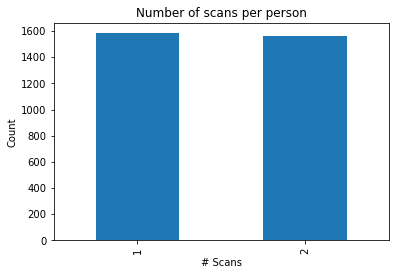

In [6]:
scans_per_person = scans.groupby(['patient_id']).count()['series_id'].value_counts()
ax = scans_per_person.plot.bar()
ax.set_xlabel('# Scans')
ax.set_ylabel("Count")
ax.set_title("Number of scans per person")

### Injuries

In [7]:
injuries['injury_name'].value_counts()

injury_name
Active_Extravasation    6370
Bowel                   5659
Name: count, dtype: int64

### Train

In [8]:
train.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


<AxesSubplot:xlabel='any_injury'>

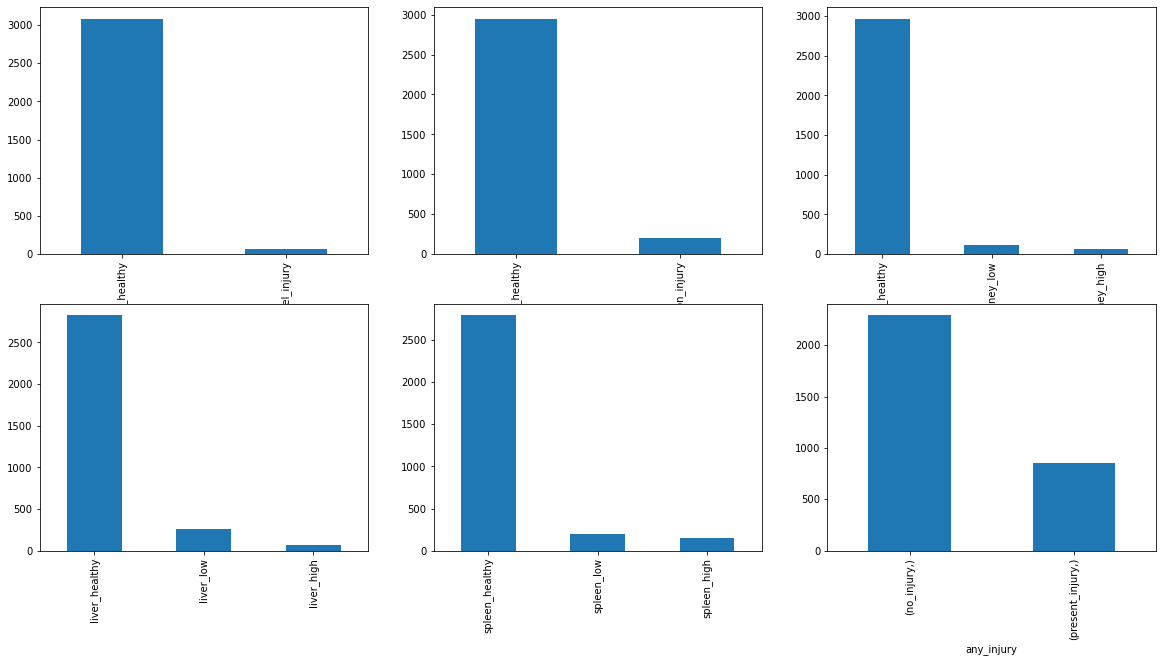

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
train[['bowel_healthy', 'bowel_injury']].sum().plot.bar(ax=ax[0][0])
train[['extravasation_healthy', 'extravasation_injury']].sum().plot.bar(ax=ax[0][1])
train[['kidney_healthy', 'kidney_low', 'kidney_high']].sum().plot.bar(ax=ax[0][2])
train[['liver_healthy', 'liver_low', 'liver_high']].sum().plot.bar(ax=ax[1][0])
train[['spleen_healthy', 'spleen_low', 'spleen_high']].sum().plot.bar(ax=ax[1][1])
train[['any_injury']].value_counts().rename({0: 'no_injury', 1: 'present_injury'}).plot.bar(ax=ax[1][2])

## Open dicom images

In [47]:
artists = []
anim = None
def animate_scan(path):
    global artists, anim
    image_paths = sorted(os.listdir(path), key=lambda x: int(x.split('.')[0]))[::50]
    
    fig, ax = plt.subplots()
    artists = []
    for image_path in image_paths:
        ds = pydicom.dcmread(f'{path}/{image_path}')
        container = ax.imshow(ds.pixel_array)
        artists.append([container])
        
    anim = animation.ArtistAnimation(fig=fig, artists=artists, interval=300)
    HTML(anim.to_jshtml())

In [48]:
animate_scan(f'{train_image_root}/10004/21057')

<IPython.core.display.Javascript object>